In [1]:
%%capture
%pip install statsforecast coreforecast mlforecast datasetsforecast -U

In [2]:

from statsforecast import StatsForecast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasetsforecast.m3 import M3

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
df, *_ = M3.load(directory='data', group='Monthly')

100%|██████████| 1.76M/1.76M [00:00<00:00, 55.6MiB/s]


#EDA

In [4]:
print('n_series:', len(np.unique(df.unique_id.values)))

n_series: 1428


In [5]:
np.sort(df.ds.unique())

array(['1857-01-31T00:00:00.000000000', '1857-02-28T00:00:00.000000000',
       '1857-03-31T00:00:00.000000000', ...,
       '2004-12-31T00:00:00.000000000', '2005-01-31T00:00:00.000000000',
       '2005-02-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [6]:
df.ds.value_counts()

ds
1990-01-31    1215
1990-02-28    1215
1990-04-30    1214
1990-08-31    1214
1990-05-31    1214
              ... 
1890-09-30       1
1890-08-31       1
1890-07-31       1
1890-06-30       1
1891-04-30       1
Name: count, Length: 1778, dtype: int64

In [7]:
df[df.ds.isin(['1857-01-31', '2005-02-28'])]

,unique_id,ds,y
51138,M1383,1857-01-31,2720.0
158169,M932,2005-02-28,12785.5


In [8]:
display(df.unique_id.value_counts())

unique_id
M778     144
M480     144
M481     144
M482     144
M483     144
        ... 
M9        68
M1        68
M10       68
M1079     66
M1078     66
Name: count, Length: 1428, dtype: int64

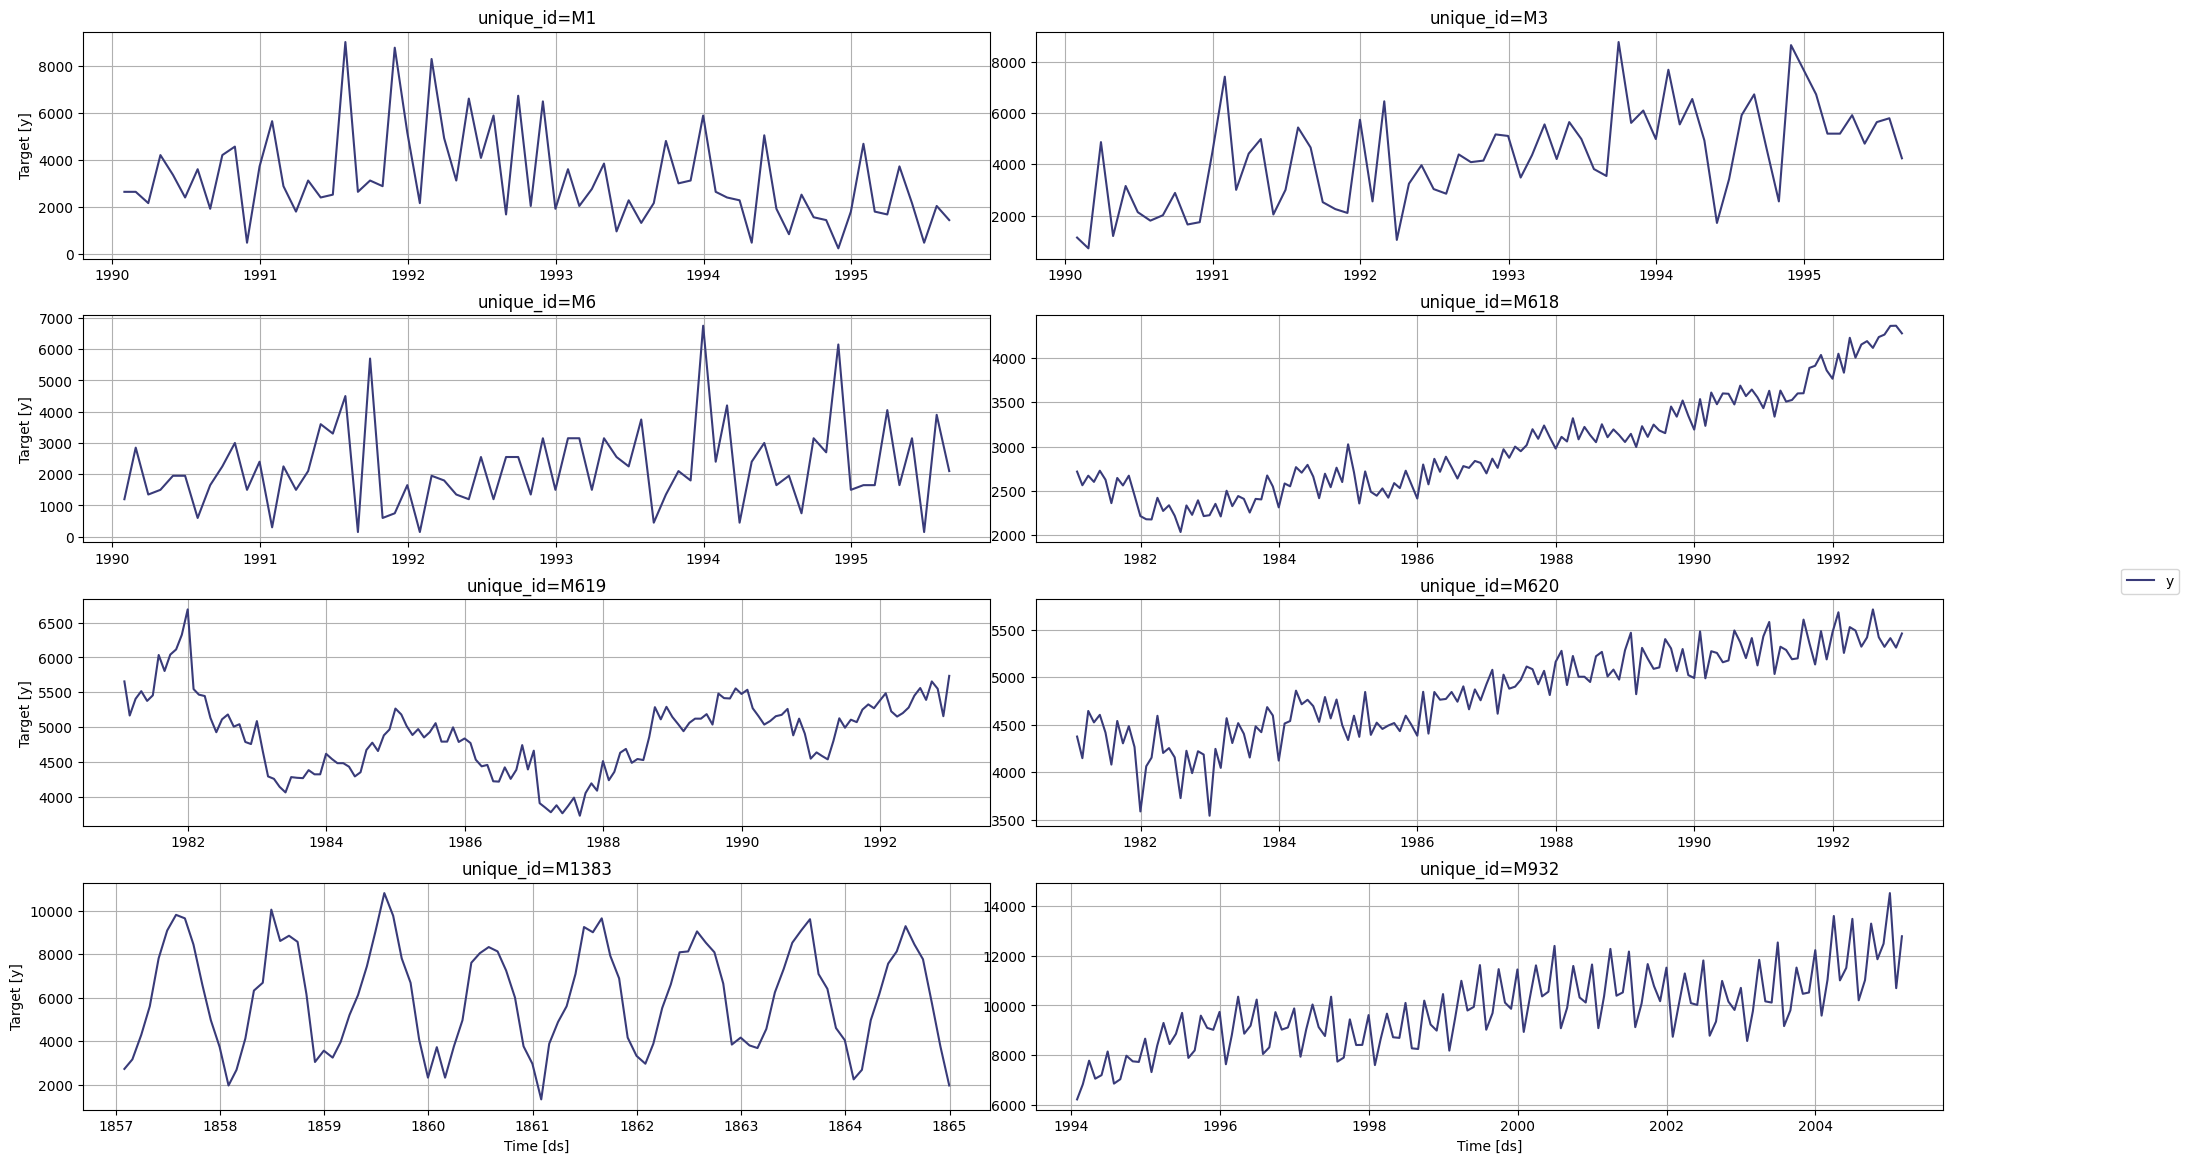

In [9]:
StatsForecast.plot(df, unique_ids=['M1', 'M3', 'M6', #longest
                                   'M618', 'M619', 'M620', #shortest
                                   'M1383', #oldest
                                   'M932' #newest
                                   ])

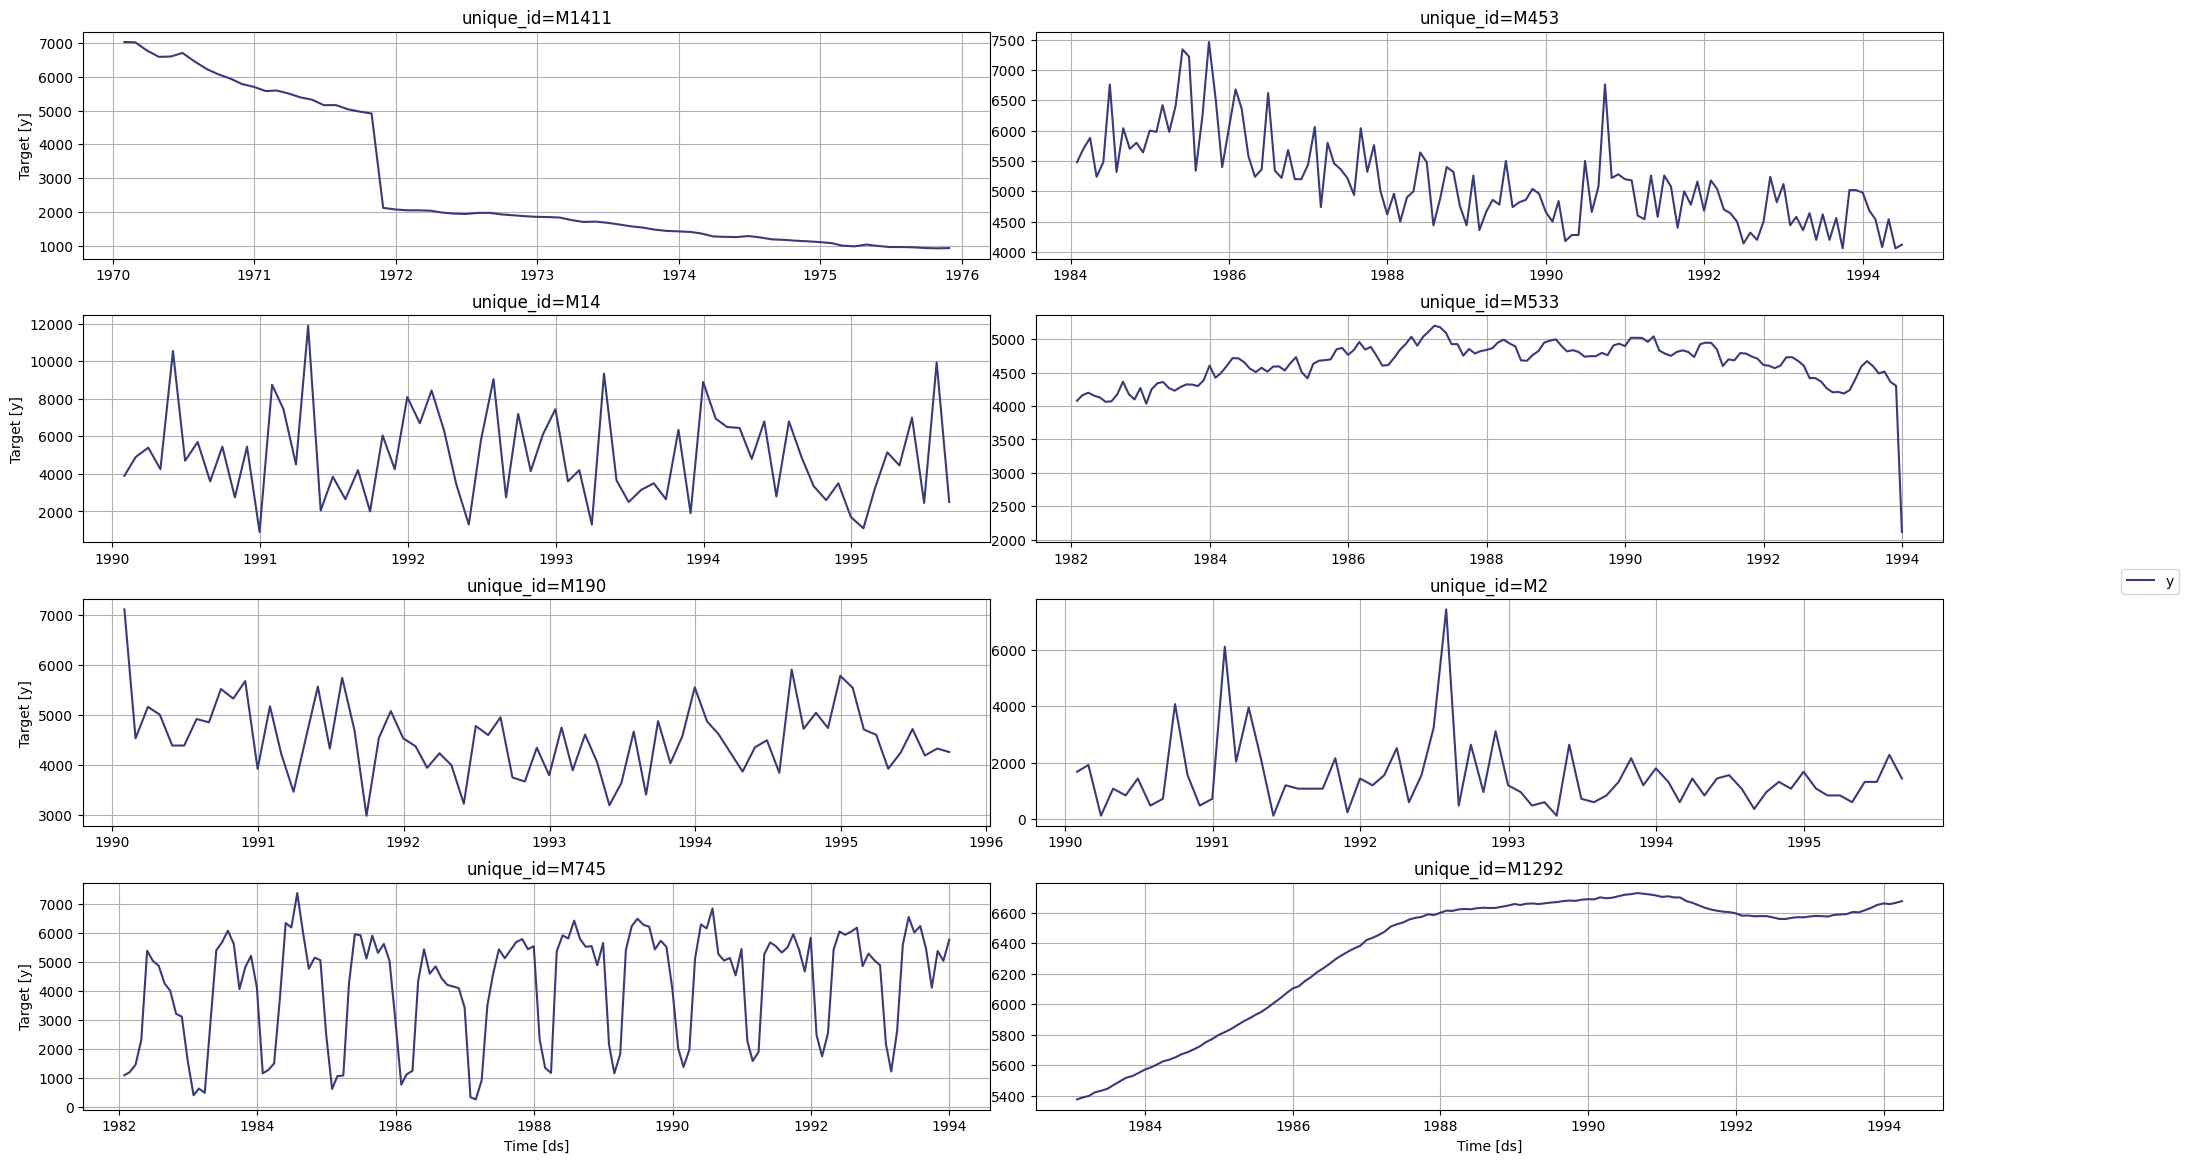

In [10]:
StatsForecast.plot(df)

In [11]:
df

,unique_id,ds,y
0,M1,1990-01-31,2640.0
1,M1,1990-02-28,2640.0
2,M1,1990-03-31,2160.0
3,M1,1990-04-30,4200.0
4,M1,1990-05-31,3360.0
...,...,...,...
167557,M999,1993-10-31,5225.9
167558,M999,1993-11-30,5236.3
167559,M999,1993-12-31,5186.6
167560,M999,1994-01-31,5143.4


In [12]:

missing_values_summary = df.groupby('unique_id')[['y']].apply(lambda x: x.isna().sum()).reset_index()

missing_values_summary.columns = ['unique_id', 'missing_y']

print(missing_values_summary.sum())


unique_id    M1M10M100M1000M1001M1002M1003M1004M1005M1006M1...
missing_y                                                    0
dtype: object


In [13]:
import pandas as pd

df['ds'] = pd.to_datetime(df['ds'])

def split_group(group, n_test=18):
    test_data = group.nlargest(n_test, 'ds')
    train_data = group.drop(test_data.index)
    return train_data, test_data

train_list, test_list = [], []
for _, group in df.groupby('unique_id'):
    train_data, test_data = split_group(group)
    train_list.append(train_data)
    test_list.append(test_data)

df_train = pd.concat(train_list).sort_values(by=['unique_id', 'ds'])
df_test = pd.concat(test_list).sort_values(by=['unique_id', 'ds'])

df_train.shape, df_test.shape


((141858, 3), (25704, 3))

In [14]:
train2_list, valid_list = [], []
for _, group in df_train.groupby('unique_id'):
    train2_data, valid_data = split_group(group)
    train2_list.append(train2_data)
    valid_list.append(valid_data)

df_train2 = pd.concat(train2_list).sort_values(by=['unique_id', 'ds'])
df_valid = pd.concat(valid_list).sort_values(by=['unique_id', 'ds'])

df_train2.shape, df_valid.shape

((116154, 3), (25704, 3))

In [15]:
from coreforecast.seasonal import find_season_length
find_season_length(df_train.y.values, max_season_length=100)

0

In [ ]:
from statsforecast.models import WindowAverage, SeasonalNaive, RandomWalkWithDrift, AutoARIMA, AutoETS, AutoTheta, AutoCES

sf = StatsForecast(
    models = [
              SeasonalNaive(season_length=12),
              AutoARIMA(season_length=12),
              AutoETS(season_length=12),

              ],
    freq = 'M'
)
import time
start = time.time()
sf.fit(df_train)
end=time.time()
print(f'duration {(end-start)/60}')

/usr/local/lib/python3.10/dist-packages/statsforecast/arima.py:1963: UserWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/arima.py:1963: UserWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/arima.py:1963: UserWarning: Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.
  warnings.warn(


duration 41.492622534434


In [ ]:
forecasts_df_main = sf.predict( h=18)

forecasts_df_main.head()

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,SeasonalNaive,AutoARIMA,AutoETS
unique_id,,,,
M1,1994-03-31,2760.0,3868.732422,3611.008545
M1,1994-04-30,3840.0,2475.525146,3611.008545
M1,1994-05-31,960.0,2777.835449,3611.008545
M1,1994-06-30,2280.0,2943.972900,3611.008545
M1,1994-07-31,1320.0,2449.869141,3611.008545


In [17]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [18]:
!dir

data  drive  sample_data


**Saving the result as running arima and ets is time consuming**

In [19]:
file_path = '/content/drive/MyDrive/forecasts_df_main.pkl'


In [ ]:
# forecasts_df_main.to_pickle(file_path)


In [20]:
forecasts_df_main= pd.read_pickle(file_path)


In [21]:
from datasetsforecast.losses import smape
smape_y_test = pd.merge(df_test, forecasts_df_main, on=['unique_id', 'ds'], how='inner')
smape_y_test = smape_y_test[['unique_id', 'ds', 'y']]
smape_y_test = smape_y_test['y'].values
models = forecasts_df_main.columns[1:4]
for model in models:
  y_hat = forecasts_df_main[model].values
  score = smape(smape_y_test, y_hat)
  print(f"{model}: {score}")




SeasonalNaive: 17.23910153242854
AutoARIMA: 15.449240405790658
AutoETS: 14.164029616047028


**The best model is AutoETS so the aim is to find a model with lower score**

Here is running the baseline models on valid set

In [ ]:
import time
from statsforecast.models import WindowAverage, SeasonalNaive, RandomWalkWithDrift, AutoARIMA, AutoETS, AutoTheta, AutoCES

start = time.time()
sf2 = StatsForecast(
    models = [
              SeasonalNaive(season_length=12),
              AutoARIMA(season_length=12),
              AutoETS(season_length=12),
              ],
    freq = 'M',
    n_jobs=-1
)
sf2.fit(df_train2)
end=time.time()
print(f'duration {(end-start)/60}')

KeyboardInterrupt: 

In [ ]:
forecasts_df_valid = sf2.predict( h=18)
forecasts_df_valid.head()

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,SeasonalNaive,AutoARIMA,AutoETS
unique_id,,,,
M1,1992-09-30,3120.0,4344.557129,5536.589844
M1,1992-10-31,2880.0,4344.557129,5636.528320
M1,1992-11-30,8760.0,4344.557129,5736.466797
M1,1992-12-31,5160.0,4344.557129,5836.405273
M1,1993-01-31,2160.0,4344.557129,5936.344238


In [22]:
file_path = '/content/drive/MyDrive/forecasts_df_valid.pkl'


In [23]:
# forecasts_df_valid.to_pickle(file_path)


In [24]:
forecasts_df_valid= pd.read_pickle(file_path)

In [25]:
from datasetsforecast.losses import smape
smape_y_test = pd.merge(df_valid, forecasts_df_valid, on=['unique_id', 'ds'], how='inner')
smape_y_test = smape_y_test[['unique_id', 'ds', 'y']]
smape_y_test = smape_y_test['y'].values
models = forecasts_df_valid.columns[1:4]
for model in models:
  y_hat = forecasts_df_valid[model].values
  score = smape(smape_y_test, y_hat)
  print(f"{model}: {score}")



SeasonalNaive: 17.929829289262916
AutoARIMA: 15.735415783389122
AutoETS: 15.113601149748401


In [16]:
%%capture
%pip install NeuralForecast

In [ ]:
# %pip install torch pytorch-lightning neuralforecast tensorboard


In [26]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS,NHITS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss



In [ ]:
# !pip uninstall -y tensorflow


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0


In [ ]:

horizon = 18
models = [
    NBEATS(input_size=1 * horizon, h=horizon,scaler_type='standard'),
          NHITS(input_size=1 * horizon, h=horizon,scaler_type='standard',
               )]
nf = NeuralForecast(models=models, freq='M')


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
import time
start = time.time()
nf.fit(df=df_train2)
end=time.time()
print(f'duration {(end-start)/60}')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.5 M 
-----------------------------------------------
2.4 M     Trainable params
1.3 K     Non-trainable params
2.5 M     Total params
9.803     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.710     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


duration 0.8094377199808757


In [ ]:
Y_hat_df_nn = nf.predict().reset_index()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
Y_hat_df_nn

,unique_id,ds,NBEATS,NHITS
0,M1,1992-09-30,3546.108643,4052.551270
1,M1,1992-10-31,4258.496094,3970.725098
2,M1,1992-11-30,4562.511719,4806.945312
3,M1,1992-12-31,4297.573730,4163.793457
4,M1,1993-01-31,3705.952148,2795.371826
...,...,...,...,...
25699,M999,1992-04-30,5305.333496,5329.463867
25700,M999,1992-05-31,5313.886230,5328.038574
25701,M999,1992-06-30,5311.599121,5328.306641
25702,M999,1992-07-31,5323.417480,5343.424316


In [27]:
file_path = '/content/drive/MyDrive/Y_hat_df_nn.pkl'


In [28]:
# Y_hat_df_nn.to_pickle(file_path)


In [29]:
Y_hat_df_nn= pd.read_pickle(file_path)

In [30]:
from datasetsforecast.losses import smape
smape_y_test = pd.merge(df_valid, Y_hat_df_nn, on=['unique_id', 'ds'], how='inner')
smape_y_test = smape_y_test[['unique_id', 'ds', 'y']]
smape_y_test = smape_y_test['y'].values
models = Y_hat_df_nn.columns[2:5]
for model in models:
  y_hat = Y_hat_df_nn[model].values
  score = smape(smape_y_test, y_hat)
  print(f"{model}: {score}")



NBEATS: 14.50122888242775
NHITS: 14.491110176331182


**Both performed better than baseline for valid set and NHITS did slightly better**

**Running NHITS on train set to see if it performs better on test set**

In [31]:

horizon = 18
models = [
    # NBEATS(input_size=1 * horizon, h=horizon,scaler_type='standard'),
          NHITS(input_size=1 * horizon, h=horizon,scaler_type='standard',
               )]
nff = NeuralForecast(models=models, freq='M')


INFO:lightning_fabric.utilities.seed:Seed set to 1


In [32]:

import time
start = time.time()
nff.fit(df=df_train)
end=time.time()
print(f'duration {(end-start)/60}')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.710     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


duration 0.3540560245513916


In [33]:
Y_hat_df_final = nff.predict().reset_index()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [34]:
file_path = '/content/drive/MyDrive/Y_hat_df_final.pkl'
# Y_hat_df_final.to_pickle(file_path)
Y_hat_df_final= pd.read_pickle(file_path)

In [35]:
from datasetsforecast.losses import smape
smape_y_test = pd.merge(df_test, Y_hat_df_final, on=['unique_id', 'ds'], how='inner')
smape_y_test = smape_y_test[['unique_id', 'ds', 'y']]
smape_y_test = smape_y_test['y'].values
models = Y_hat_df_final.columns[2:3]
for model in models:
  y_hat = Y_hat_df_final[model].values
  score = smape(smape_y_test, y_hat)
  print(f"{model}: {score}")



NHITS: 14.042111492238316


**It did better than all 3 models so this is our final model**

**Now I can check how many datasets NN performed better than baseline**

In [37]:
merged_df = pd.merge(df_test, forecasts_df_main, on=['unique_id', 'ds'], how='inner')
smape_y_test = merged_df[['unique_id', 'ds', 'y']]
models = forecasts_df_main.columns[1:4]
scores_dict = {model: {} for model in models}

for unique_id in merged_df['unique_id'].unique():
    actual_values = smape_y_test[smape_y_test['unique_id'] == unique_id]['y'].values

    for model in models:
        predicted_values = merged_df[merged_df['unique_id'] == unique_id][model].values
        score = smape(actual_values, predicted_values)
        scores_dict[model][unique_id] = score


In [39]:
merged_df = pd.merge(df_test, Y_hat_df_final, on=['unique_id', 'ds'], how='inner')
smape_y_test = merged_df[['unique_id', 'ds', 'y']]
models = Y_hat_df_final.columns[2:3]
score_dict_nhits = {model: {} for model in models}

for unique_id in merged_df['unique_id'].unique():
    actual_values = smape_y_test[smape_y_test['unique_id'] == unique_id]['y'].values

    for model in models:
        predicted_values = merged_df[merged_df['unique_id'] == unique_id][model].values
        score = smape(actual_values, predicted_values)
        score_dict_nhits[model][unique_id] = score


In [45]:

comparison_results = {model: 0 for model in scores_dict.keys()}
nhits_scores = score_dict_nhits['NHITS']

for unique_id, nhits_score in nhits_scores.items():

    for model in scores_dict.keys():
        if unique_id in scores_dict[model]:
            if nhits_score < scores_dict[model][unique_id]:
                comparison_results[model] += 1

for model, count in comparison_results.items():
    print(f"{count} unique ids have lower scores than {model}")


1087 unique ids have lower scores than SeasonalNaive
811 unique ids have lower scores than AutoARIMA
727 unique ids have lower scores than AutoETS
